<a href="https://colab.research.google.com/github/Dhyanesh-AN/Duplicate-questions/blob/main/QPairsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **<font color="#00FFFF">Duplicate Question Detection with CNN Network</font>**


###<font color = "##00FFFF">Table of Contents <a name="top"></a>

- [Basic EDA](#section-1)
- [Building Word2Vec Embeddings](#section-2)
- [Creating Features from Text](#section-3)
- [Analyzing Engineered Features](#section-4)
- [Training CNN Model](#section-5)
- [Evaluating Model Performance](#section-6)

###<font color="##00FFFF"> Basic EDA <a name="section-1"></a>


*Downloading Dataset from Kaggle*<br/>
(Requires a valid kaggle.json API key for authentication)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d quora/question-pairs-dataset

Dataset URL: https://www.kaggle.com/datasets/quora/question-pairs-dataset
License(s): other


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('question-pairs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('questions.csv')

*Inspecting for Missing Values*<br/>
Minimal null values detected — dropping them from the dataset.

In [ ]:
df.isnull().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [ ]:
df.dropna(axis=0, inplace=True)

*Identifying Duplicate Entries*<br/>
Evaluating the dataset for any repeated question pairs.

In [ ]:
df.duplicated().value_counts()

,count
False,404348


*Comparing Identical Questions*<br/>
Checking instances where Question 1 and Question 2 are the same.

In [ ]:
len(df[df['qid1'] == df['qid2']])

0

*Analyzing Question Repetition*<br/>
Reviewing the dataset for frequently repeated questions.

In [ ]:
len(set(df['qid1']) & set(df['qid2']))

7474

*Examining Target Class Distribution*<br/>
Visualizing and assessing the balance between classes in the target variable Y.

In [ ]:
df['is_duplicate'].value_counts()/len(df) * 100

,count
is_duplicate,
0,63.074876
1,36.925124


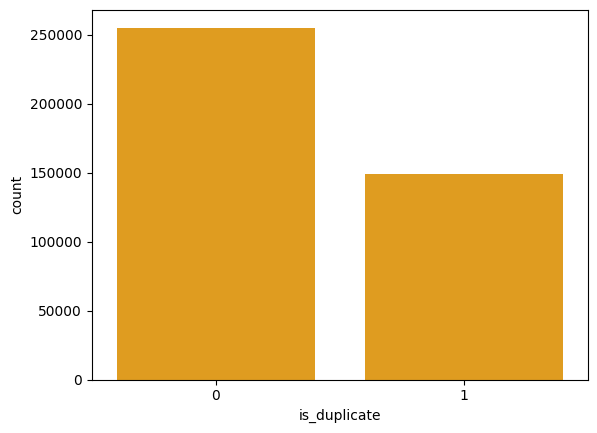

In [ ]:
sns.countplot(df, x='is_duplicate', color='orange')
plt.show()

*Dropping Ids*

In [ ]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [ ]:
!pip install contractions
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 14.5 MB/s eta 0:00:00


*Applying Basic Text Preprocessing*<br/>
Standardizing text through lowercasing, punctuation removal, and other cleaning techniques.

In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def basic_preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stop_words]
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(basic_preprocess_text)
df['question2'] = df['question2'].apply(basic_preprocess_text)

In [ ]:
s = ''.join(df['question1'])
t = ''.join(df['question2'])

*Generating Word Clouds*<br/>
Visual representation of the most frequent terms in the dataset

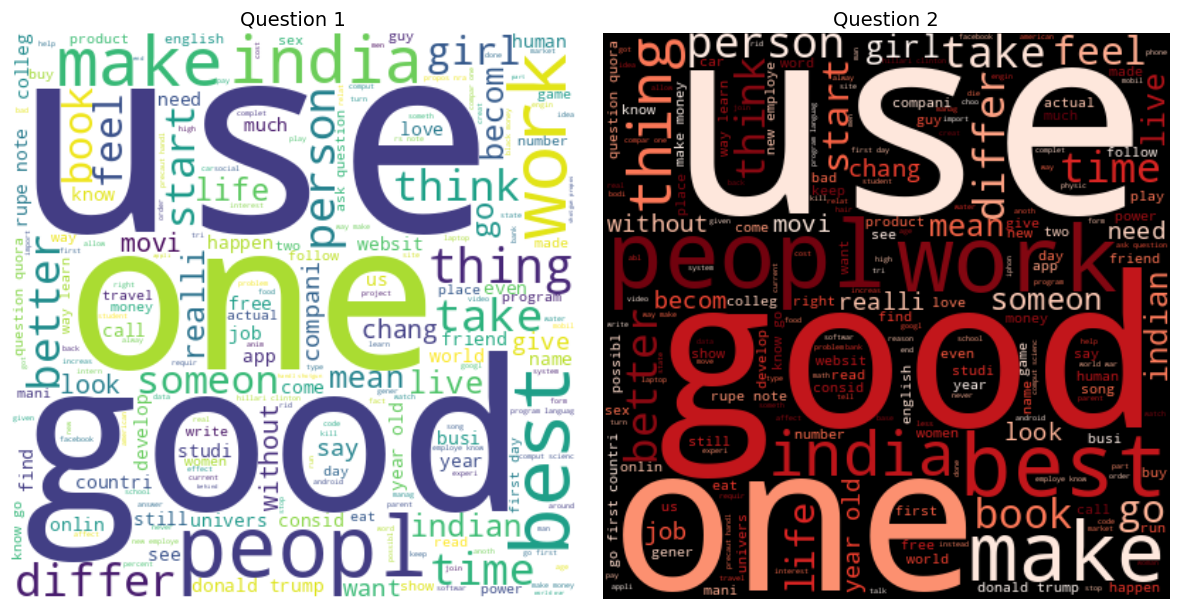

In [ ]:
wordcloud_q1 = WordCloud(width=400, height=400, background_color="white").generate(s)
wordcloud_q2 = WordCloud(width=400, height=400, background_color="black", colormap="Reds").generate(t)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(wordcloud_q1, interpolation="bilinear")
axes[0].set_title("Question 1", fontsize=14)
axes[0].axis("off")

axes[1].imshow(wordcloud_q2, interpolation="bilinear")
axes[1].set_title("Question 2", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()

###<font color="##00FFFF"> Building Word2Vec Embeddings <a name="section-2"></a>

Building a ***Word2Vec*** model that creates 300-dimensional word embeddings by analyzing words within a 10-word context window, ignoring terms that appear less than twice in the corpus.

In [ ]:
!pip install numpy==1.24.3
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 98.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have nump

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.


In [ ]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm
from gensim.models import KeyedVectors

In [ ]:
df_stacked = pd.DataFrame({
    'questions': pd.concat([df['question1'], df['question2']])
})

In [ ]:
questions = []
for doc in df_stacked['questions']:
    for sentence in sent_tokenize(doc):
        questions.append(simple_preprocess(sentence))

In [ ]:
model = gensim.models.Word2Vec(
    window = 10,
    min_count = 2,
    vector_size=300
)

In [ ]:
model.build_vocab(questions)
model.train(questions, total_examples=model.corpus_count, epochs=model.epochs)

(20018396, 21240930)

In [ ]:
len(model.wv.index_to_key)

33817

Due to versioning incompatibilities between the legacy Gensim library and the current TensorFlow framework, it is recommended to export the word embedding model in plain text format to ensure cross-platform compatibility.

In [ ]:
model.wv.save("Questions300_vectors.kv")
model.save("Questions300_w2v.model")

In [ ]:
kv = KeyedVectors.load("Questions300_vectors.kv", mmap='r')
kv.save_word2vec_format("vectors.txt", binary=False)

###<font color="##00FFFF"> Creating Features from Text <a name="section-3"></a>

The generate_features function creates a set of features for question pair similarity analysis by extracting:

1.  Length-based features:***len_q1*** and ***len_q2***: Word count in each question
stop_words_q1 and stop_words_q2: Count of stopwords in each question


2.  Overlap metrics:
***common_words***: Count of words that appear in both questions
***common_stpwords***: Count of stopwords shared between questions


3.  Fuzzy matching scores (using FuzzyWuzzy library):
***fuzz_ratio***: Simple string similarity percentage<br/>
***fuzz_partial_ratio***: Similarity when considering partial string matches<br/>
***token_sort_ratio***: Similarity after alphabetically sorting tokens<br/>
***token_set_ratio***: Similarity based on unique token intersections


4.  Jaccard similarity:***j_sim***: Ratio of intersection to union of word sets


5.  Normalized overlap ratios:
***cw_min/max/mean***: Common words normalized by min/max/mean question length<br/>
***cstp_min/max/mean***: Common stopwords normalized by min/max/mean question length<br/>
***cstp_stplen_min/max/mean***: Common stopwords normalized by min/max/mean stopword count

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.8 MB/s eta 0:00:00


In [ ]:
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = stopwords.words('english')
ps = PorterStemmer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('questions.csv')

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
def preprocess_text(text):
    text = text.lower().strip()
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = contractions.fix(text)
    text = word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = " ".join(text)
    return text

In [ ]:
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

In [ ]:
def get_common_words(q1, q2):
    words1 = set(q1.split())
    words2 = set(q2.split())
    return len(words1 & words2)

In [ ]:
def stopword_count(text):
    stp_text = [word for word in text.split() if word in stop_words]
    return len(stp_text)

In [ ]:
def get_common_stpwords(q1, q2):
    stp_q1 = set([word for word in q1.split() if word in stop_words])
    stp_q2 = set([word for word in q2.split() if word in stop_words])
    return len(stp_q1 & stp_q2)

In [ ]:
from fuzzywuzzy import fuzz
def jaccard_similarity(q1, q2):
    s1 = set(word_tokenize(q1))
    s2 = set(word_tokenize(q2))
    if not s1 or not s2:
        return 0
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [ ]:
def generate_features(df):
    sfty = 1e-04
    X_feat = pd.DataFrame()
    X_feat['len_q1'] = df['question1'].apply(lambda x: len(x.split()))
    X_feat['len_q2'] = df['question2'].apply(lambda x: len(x.split()))
    X_feat['stop_words_q1'] = df['question1'].apply(stopword_count)
    X_feat['stop_words_q2'] = df['question2'].apply(stopword_count)

    for index in df.index:
        X_feat.loc[index, 'common_words'] = get_common_words(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'common_stpwords'] = get_common_stpwords(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'fuzz_ratio'] = fuzz.ratio(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'fuzz_partial_ratio'] = fuzz.partial_ratio(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'token_sort_ratio'] = fuzz.token_sort_ratio(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'token_set_ratio'] = fuzz.token_set_ratio(df.loc[index, 'question1'], df.loc[index, 'question2'])
        X_feat.loc[index, 'j_sim'] = jaccard_similarity(df.loc[index, 'question1'], df.loc[index, 'question2'])

    X_feat['cw_min'] = X_feat['common_words'] / (X_feat[['len_q1', 'len_q2']].min(axis=1) + sfty)
    X_feat['cw_max'] = X_feat['common_words'] / (X_feat[['len_q1', 'len_q2']].max(axis=1) + sfty)
    X_feat['cw_mean'] = X_feat['common_words'] / (X_feat[['len_q1', 'len_q2']].mean(axis=1) + sfty)
    X_feat['cstp_min'] = X_feat['common_stpwords'] / (X_feat[['len_q1', 'len_q2']].min(axis=1) + sfty)
    X_feat['cstp_max'] = X_feat['common_stpwords'] / (X_feat[['len_q1', 'len_q2']].max(axis=1) + sfty)
    X_feat['cstp_mean'] = X_feat['common_stpwords'] / (X_feat[['len_q1', 'len_q2']].mean(axis=1) + sfty)
    X_feat['cstp_stplen_min'] = X_feat['common_stpwords'] / (X_feat[['stop_words_q1', 'stop_words_q2']].min(axis=1) + sfty)
    X_feat['cstp_stplen_max'] = X_feat['common_stpwords'] / (X_feat[['stop_words_q1', 'stop_words_q2']].max(axis=1) + sfty)
    X_feat['cstp_stplen_mean'] = X_feat['common_stpwords'] / (X_feat[['stop_words_q1', 'stop_words_q2']].mean(axis=1) + sfty)
    return X_feat


In [ ]:
X_feat = generate_features(df)

In [ ]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [ ]:
def stemming(text):
    text = word_tokenize(text)
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
df['question1'] = df['question1'].apply(stemming)
df['question2'] = df['question2'].apply(stemming)

In [ ]:
preprocessed_questions = list(pd.concat([df['question1'], df['question2']]))

In [ ]:
y = df['is_duplicate']
df = df.drop("is_duplicate", axis = 1)
X_feat['is_duplicate'] = y

###<font color="##00FFFF"> Analyzing Engineered Features <a name="section-4"></a>

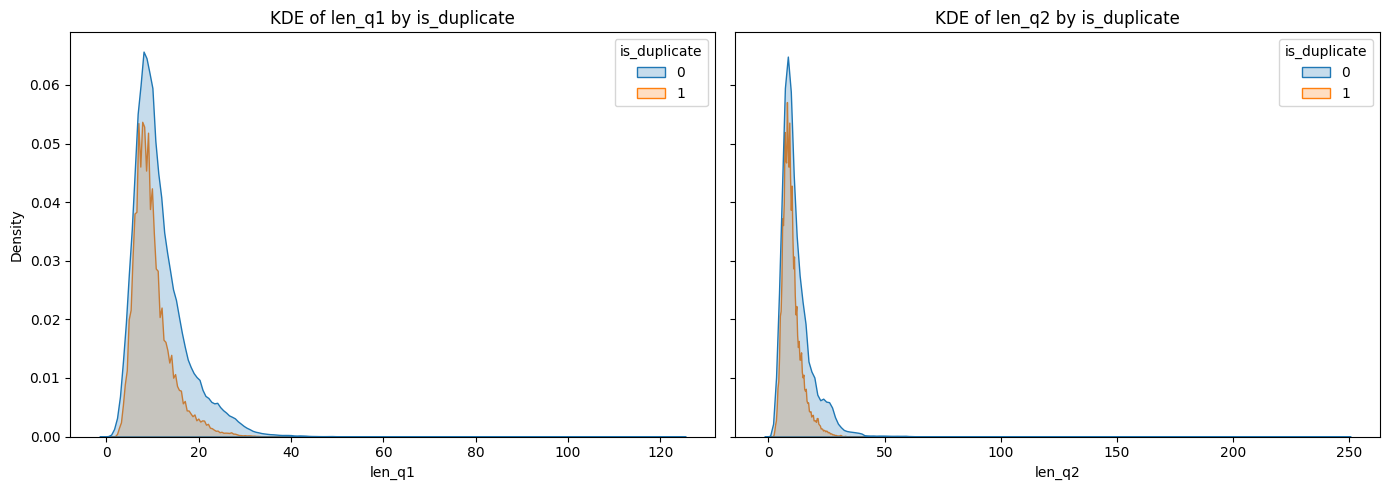

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.kdeplot(data=X_feat, x='len_q1', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of len_q1 by is_duplicate")
axes[0].set_xlabel("len_q1")

sns.kdeplot(data=X_feat, x='len_q2', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of len_q2 by is_duplicate")
axes[1].set_xlabel("len_q2")

plt.tight_layout()
plt.show()

From the above graph we can observe there aresome extreme outliers<br/>
Values above 40 can be considered as outliers here

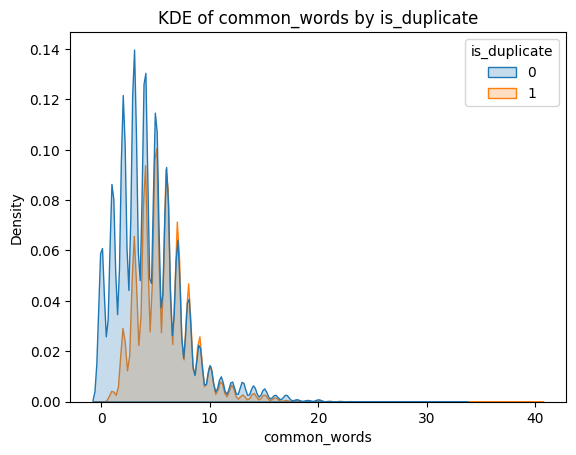

In [ ]:
sns.kdeplot(data=X_feat, x='common_words', hue='is_duplicate', fill=True)
plt.title("KDE of common_words by is_duplicate")
plt.xlabel("common_words")
plt.show()

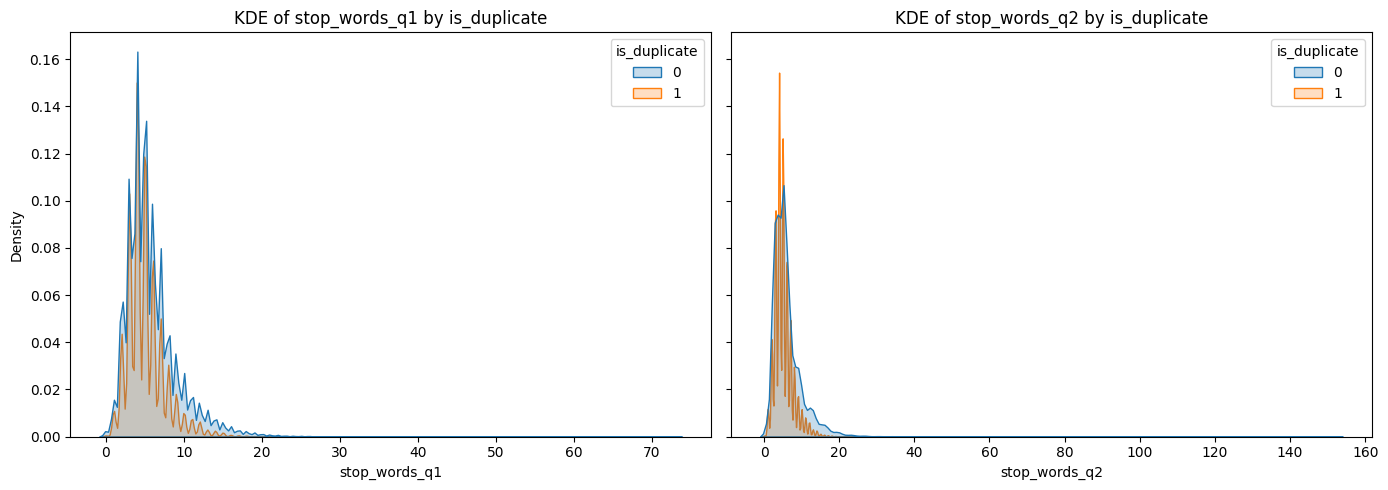

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.kdeplot(data=X_feat, x='stop_words_q1', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of stop_words_q1 by is_duplicate")
axes[0].set_xlabel("stop_words_q1")

sns.kdeplot(data=X_feat, x='stop_words_q2', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of stop_words_q2 by is_duplicate")
axes[1].set_xlabel("stop_words_q2")

plt.tight_layout()
plt.show()

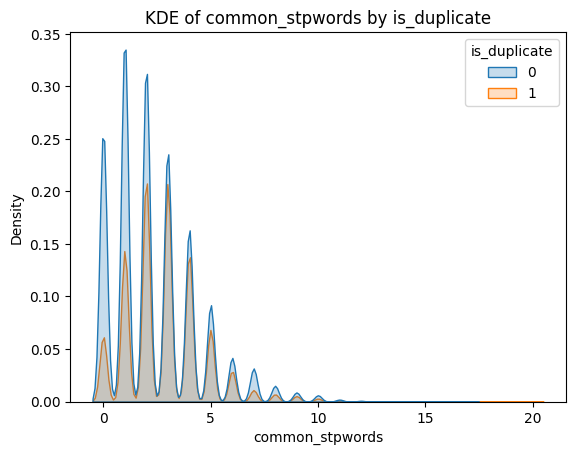

In [ ]:
sns.kdeplot(data=X_feat, x='common_stpwords', hue='is_duplicate', fill=True)
plt.title("KDE of common_stpwords by is_duplicate")
plt.xlabel("common_stpwords")
plt.show()

Till now by observing the graphs the features are ***not strong distinguishing features*** between duplicate and non-duplicate question pairs in this dataset

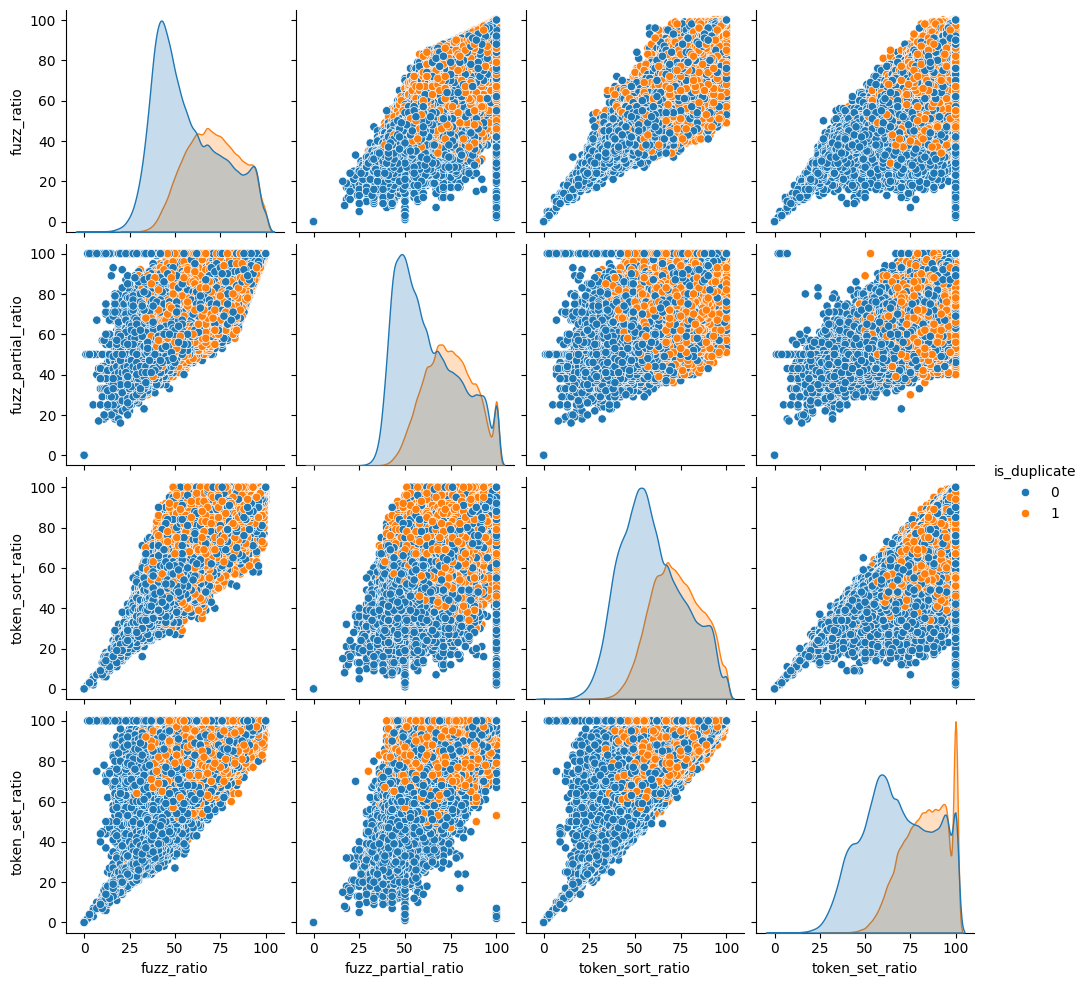

In [ ]:
sns.pairplot(X_feat[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')

Duplicate question pairs (orange) generally exhibit higher fuzzy ratio, fuzzy partial ratio, token sort ratio, and token set ratio scores compared to non-duplicate pairs (blue). There's overlap, but higher scores strongly correlate with duplication. Token set ratio appears to show the clearest separation.

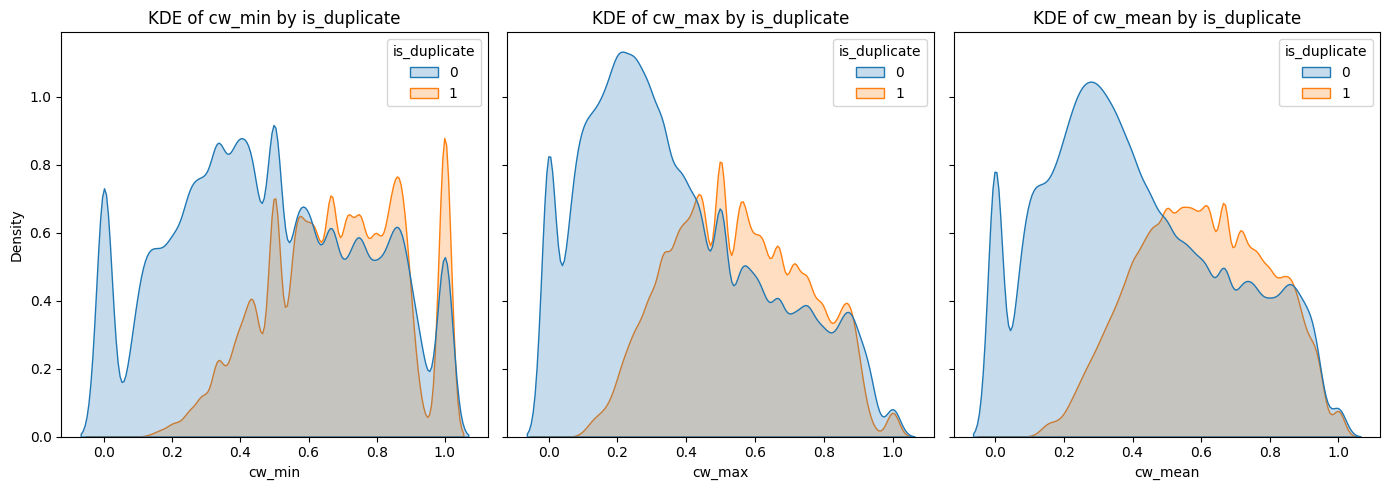

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=X_feat, x='cw_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cw_min by is_duplicate")
axes[0].set_xlabel("cw_min")


sns.kdeplot(data=X_feat, x='cw_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cw_max by is_duplicate")
axes[1].set_xlabel("cw_max")


sns.kdeplot(data=X_feat, x='cw_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cw_mean by is_duplicate")
axes[2].set_xlabel("cw_mean")

plt.tight_layout()
plt.show()

Duplicate question pairs (orange) tend to have a higher minimum, maximum, and mean number of common words (cw_min, cw_max, cw_mean) compared to non-duplicate pairs (blue). This suggests that having more words in common is indicative of question duplication. The distributions show a noticeable shift towards higher common word counts for duplicates across all three metrics.

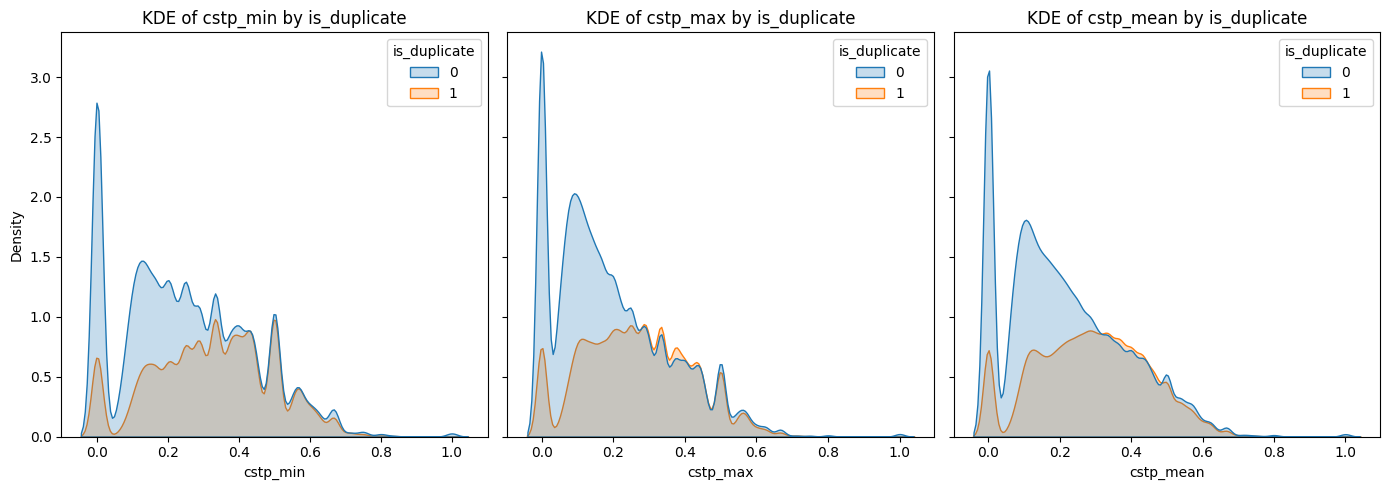

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=X_feat, x='cstp_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cstp_min by is_duplicate")
axes[0].set_xlabel("cstp_min")


sns.kdeplot(data=X_feat, x='cstp_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cstp_max by is_duplicate")
axes[1].set_xlabel("cstp_max")


sns.kdeplot(data=X_feat, x='cstp_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cstp_mean by is_duplicate")
axes[2].set_xlabel("cstp_mean")

plt.tight_layout()
plt.show()

Duplicate question pairs (orange) generally have a higher minimum, maximum, and mean number of common stop words (cstp_min, cstp_max, cstp_mean) compared to non-duplicate pairs (blue), although the distributions show considerable overlap. This suggests that a greater overlap in stop words is somewhat indicative of duplication, but not as strongly as the common word counts observed earlier.

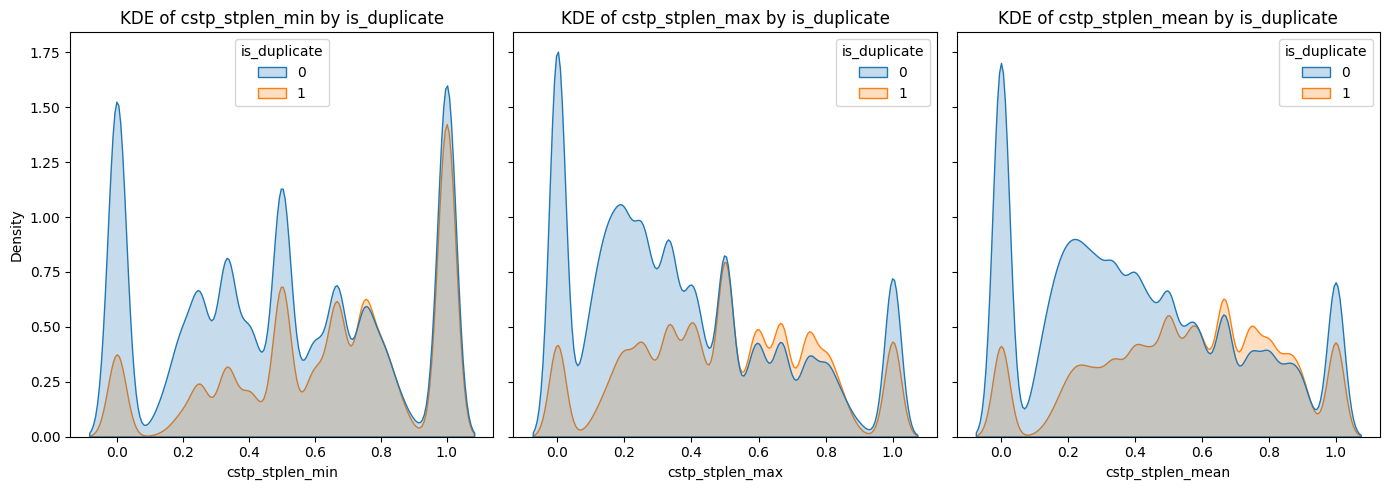

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

sns.kdeplot(data=X_feat, x='cstp_stplen_min', hue='is_duplicate', fill=True, ax=axes[0])
axes[0].set_title("KDE of cstp_stplen_min by is_duplicate")
axes[0].set_xlabel("cstp_stplen_min")


sns.kdeplot(data=X_feat, x='cstp_stplen_max', hue='is_duplicate', fill=True, ax=axes[1])
axes[1].set_title("KDE of cstp_stplen_max by is_duplicate")
axes[1].set_xlabel("cstp_stplen_max")


sns.kdeplot(data=X_feat, x='cstp_stplen_mean', hue='is_duplicate', fill=True, ax=axes[2])
axes[2].set_title("KDE of cstp_stplen_mean by is_duplicate")
axes[2].set_xlabel("cstp_stplen_mean")

plt.tight_layout()
plt.show()

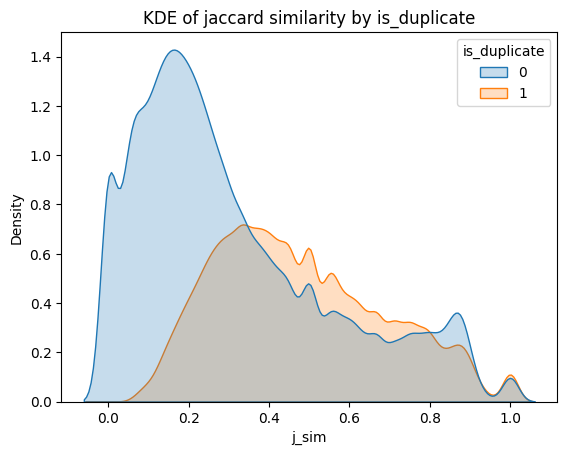

In [ ]:
sns.kdeplot(data=X_feat, x='j_sim', hue='is_duplicate', fill=True)
plt.title("KDE of jaccard similarity by is_duplicate")
plt.xlabel("j_sim")
plt.show()

Duplicate question pairs (orange) tend to have higher Jaccard similarity scores (j_sim) compared to non-duplicate pairs (blue), indicating a greater overlap in their word sets. While there's some overlap, higher Jaccard similarity strongly suggests duplication.

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [ ]:
feat = X_feat.drop('is_duplicate', axis=1).columns
X = X_feat.sample(30000,random_state=32)
y_temp = X['is_duplicate']
X = X.drop('is_duplicate', axis=1)

In [ ]:
X = StandardScaler().fit_transform(X)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


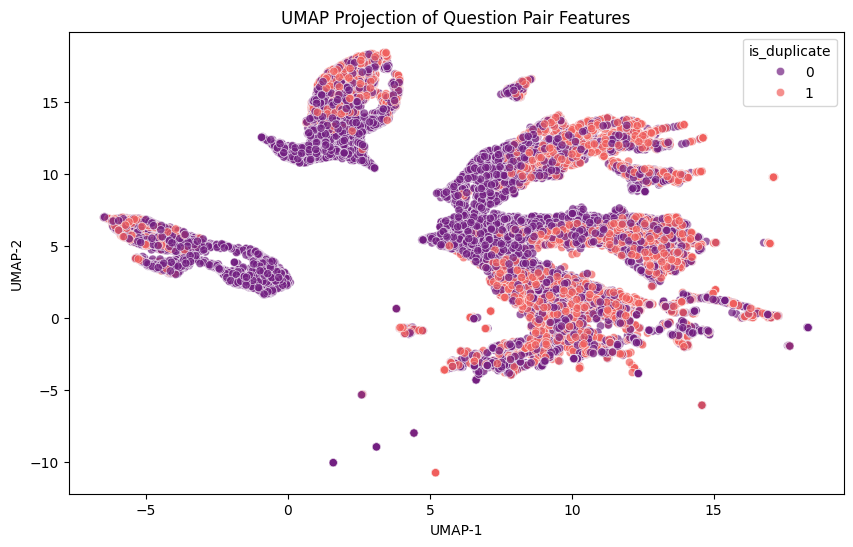

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_temp, palette='magma', alpha=0.7)
plt.title('UMAP Projection of Question Pair Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend(title='is_duplicate')
plt.show()

This UMAP projection shows a tendency for duplicate question pairs (reddish-pink) to cluster somewhat separately from non-duplicate pairs (purple), suggesting that the features used can provide some level of discrimination between the two classes, although the separation isn't perfectly clean with some intermingling.

<ipython-input-50-9871ed12ba93>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


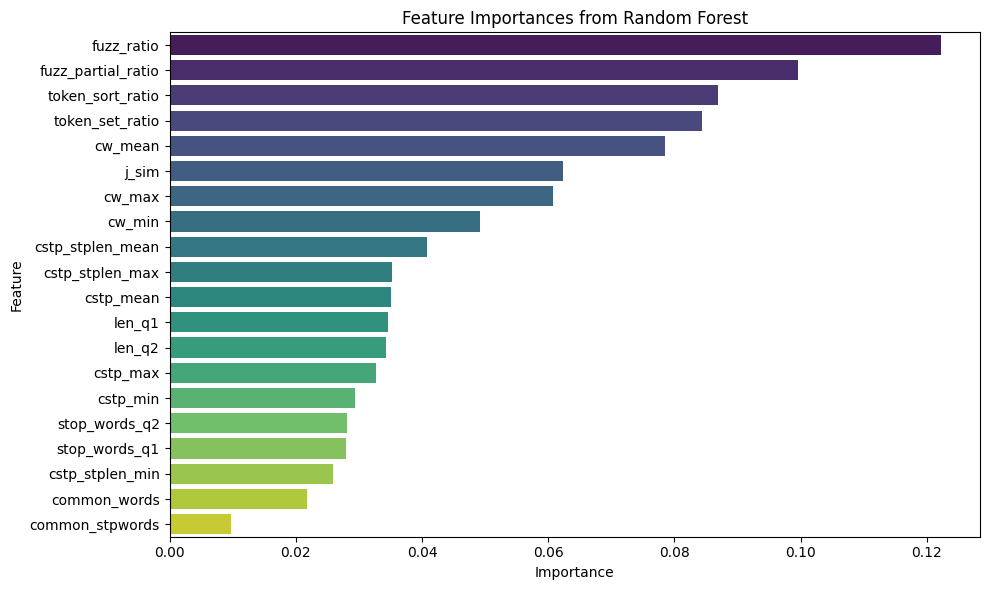

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_temp)


importances = pd.Series(rf.feature_importances_, index=feat).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


<ipython-input-51-1aa29a14ce87>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=perm_importance.values, y=perm_importance.index, palette='viridis')


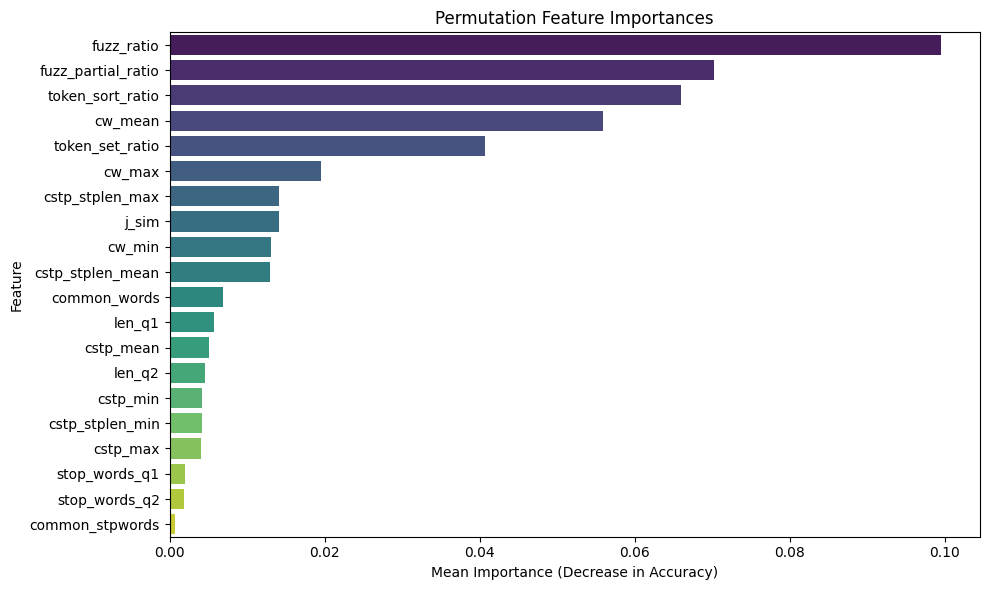

In [ ]:
result = permutation_importance(rf, X, y_temp, n_repeats=10, random_state=42, scoring='accuracy')
perm_importance = pd.Series(result.importances_mean, index=feat).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance.values, y=perm_importance.index, palette='viridis')
plt.title("Permutation Feature Importances")
plt.xlabel("Mean Importance (Decrease in Accuracy)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Permutation feature importance reveals that fuzzy ratio, fuzzy partial ratio, token sort ratio, and mean common word count are the most important features for the model's performance in distinguishing duplicate questions, as shuffling these features caused the largest decrease in accuracy. Stop word related features and question lengths appear to be less important.

<Axes: >

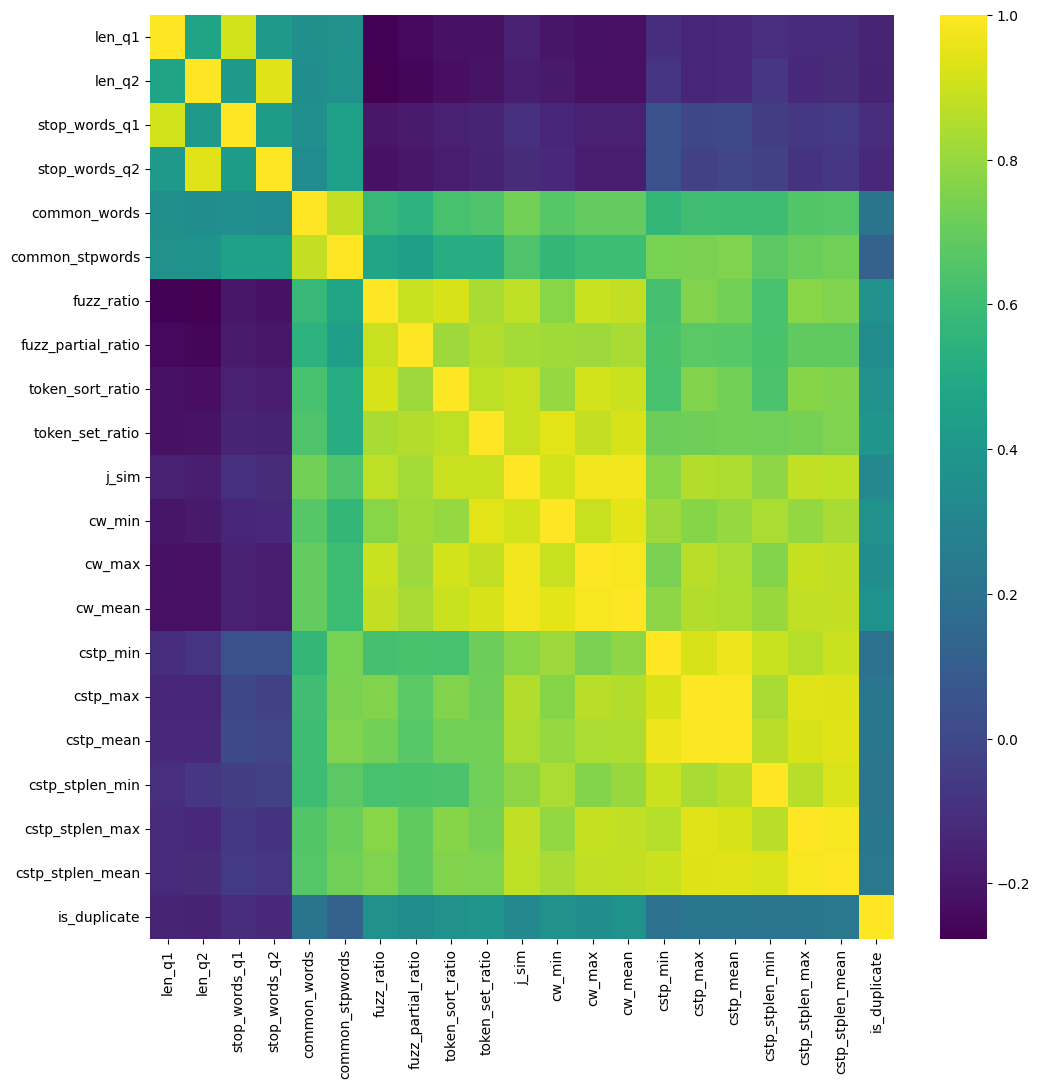

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(X_feat.corr(), cmap='viridis')

###<font color="##00FFFF">Training CNN model<a name="section-5"></a>

***Steps taken Before Training the model:***
1.  ***Spliting data***: Dividing the feature matrix (X_feat) and the original DataFrame (df) into training and testing sets (85% train, 15% test), also splitting the target variable (y).
2.  ***Scaling features***: Standardizing the numerical features in both the training and testing sets to have zero mean and unit variance.
3. ***Selecting top features***: Using SelectKBest with the f_classif (ANOVA F-value) scoring function to choose the 16 most statistically significant features for predicting the target variable in the training data and applies the same selection to the test data.
4.  ***Loading word Embeddings***: Load pre-trained word embeddings from a text file into a dictionary (word2vec)
5.  ***Creating an embedding matrix***: Creating an embedding matrix for a vocabulary built from preprocessed questions, using the loaded word embeddings for words present in the vocabulary and randomly initialized vectors for out-of-vocabulary words. This embedding matrix is used as weights in an embedding layer of a neural network.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Combine X_feat and df for joint sampling
combined = pd.concat([X_feat, df], axis=1)

# Split based on class label in 'is_duplicate'
class_0 = combined[combined['is_duplicate'] == 0]
class_1 = combined[combined['is_duplicate'] == 1]

# Find minimum class count
min_len = min(len(class_0), len(class_1))

# Undersample both classes to the same size
class_0_balanced = class_0.sample(n=min_len, random_state=42)
class_1_balanced = class_1.sample(n=min_len, random_state=42)

# Combine and shuffle
balanced = pd.concat([class_0_balanced, class_1_balanced]).sample(frac=1, random_state=42)

# Split back into X_feat and df
X_feat= balanced[X_feat.columns]
df= balanced[df.columns]

# Get y from X_feat_balanced
y = X_feat[['is_duplicate']]


In [ ]:
X_feat = X_feat.drop('is_duplicate', axis=1)

In [ ]:
X_feat_train, X_feat_test, df_train, df_test, y_train, y_test = train_test_split(
    X_feat, df, y, test_size=0.15, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_feat_train = scaler.fit_transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
X_feat_train = np.array(X_feat_train)
X_feat_test = np.array(X_feat_test)
selector = SelectKBest(f_classif, k=16)
X_feat_train = selector.fit_transform(X_feat_train, y_train)
X_feat_test = selector.transform(X_feat_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Lambda,concatenate,Dropout,BatchNormalization,SpatialDropout1D
from tensorflow.keras.initializers import Constant

In [ ]:
def load_word2vec_text_format(path):
    with open(path, 'r', encoding='utf-8') as f:
        vocab_size, vector_size = map(int, f.readline().split())
        word2vec = {}
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            word2vec[word] = vector
    return word2vec

word2vec = load_word2vec_text_format("/content/vectors.txt")
embedding_dim = len(next(iter(word2vec.values())))

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_questions)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

1.  ***Input***: The model takes three inputs:
The first question's text sequence (padded to a maximum length of 40, chosen manually).
The second question's text sequence (also padded to a length of 40).
Pre-extracted numerical features.
2.  ***Identical CNN Branches***: Both question text sequences are processed by two identical Convolutional Neural Network (CNN) branches.

3.  ***Embedding Layer***: Within each CNN branch, the input text sequence is first passed through an Embedding layer. This layer uses pre-trained word embeddings that are kept frozen during training.

4.  ***Multiple Convolutional Layers***: Each CNN branch then employs multiple 1D convolutional layers with different kernel (window) sizes: 3, 4, and 5. These layers extract different n-gram features from the text.

5.  ***Batch Normalization***: After each convolutional layer, Batch Normalization is applied to stabilize learning and improve generalization.

6.  ***Global Max Pooling***: The output of each convolutional layer is then passed through a Global MaxPooling1D layer. This reduces the dimensionality by taking the maximum value over the time dimension, capturing the most important features learned by each convolution.

7.  ***Absolute Difference Merging***: The outputs from the two CNN branches (after global max pooling) are then merged by taking the absolute difference between them. This aims to capture the dissimilarity in the learned feature representations of the two questions.

8.  ***Concatenation with Numerical Features***: The resulting difference vector is then concatenated with the pre-extracted numerical features. This combines the information learned from the text with other relevant features.

9. *** Dense Layers***: The combined vector is passed through several dense (fully connected) layers with the 'selu' activation function. Dropout is applied after some dense layers to prevent overfitting.

10.  ***Output Layer***: Finally, a dense layer with a single output unit and a sigmoid activation function produces the prediction. The output is a probability between 0 and 1, indicating the likelihood that the two input questions are duplicates (binary classification).

In [ ]:
max_seq_length = 40  # decided based on the question length graph
num_features = X_feat_train.shape[1]

def create_base_cnn():
    input_seq = Input(shape=(max_seq_length,))

    embed = Embedding(
        input_dim=len(word_index) + 1,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=max_seq_length,
        trainable=False
    )(input_seq)

    # Multiple convolution layers with different kernel sizes
    conv3 = Conv1D(filters=100, kernel_size=3, activation='relu')(embed)
    conv4 = Conv1D(filters=100, kernel_size=4, activation='relu')(embed)
    conv5 = Conv1D(filters=100, kernel_size=5, activation='relu')(embed)

    #Batch Normalization
    batch_norm3 = BatchNormalization()(conv3)
    batch_norm4 = BatchNormalization()(conv4)
    batch_norm5 = BatchNormalization()(conv5)

    # Global max pooling for each conv
    pool3 = GlobalMaxPooling1D()(batch_norm3)
    pool4 = GlobalMaxPooling1D()(batch_norm4)
    pool5 = GlobalMaxPooling1D()(batch_norm5)

    # Concatenate all pooled outputs
    merged = concatenate([pool3, pool4, pool5])

    # Dropout for regularization
    dropout = Dropout(0.3)(merged)

    # Dense layer
    dense1 = Dense(64, activation='selu')(dropout)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(32, activation='selu')(dropout1)

    return Model(inputs=input_seq, outputs=dense2)

# Create two identical CNN branches
base_cnn = create_base_cnn()
input_q1 = Input(shape=(max_seq_length,))
input_q2 = Input(shape=(max_seq_length,))
input_feats = Input(shape=(num_features,))


processed_q1 = base_cnn(input_q1)
processed_q2 = base_cnn(input_q2)

# Merge via absolute difference
merged = Lambda(lambda x: tf.abs(x[0] - x[1]))([processed_q1, processed_q2])
merged_all = concatenate([merged, input_feats])
dense_comb = Dense(32, activation='selu')(merged_all)
output = Dense(1, activation='sigmoid')(dense_comb)

model = Model(inputs=[input_q1, input_q2, input_feats], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


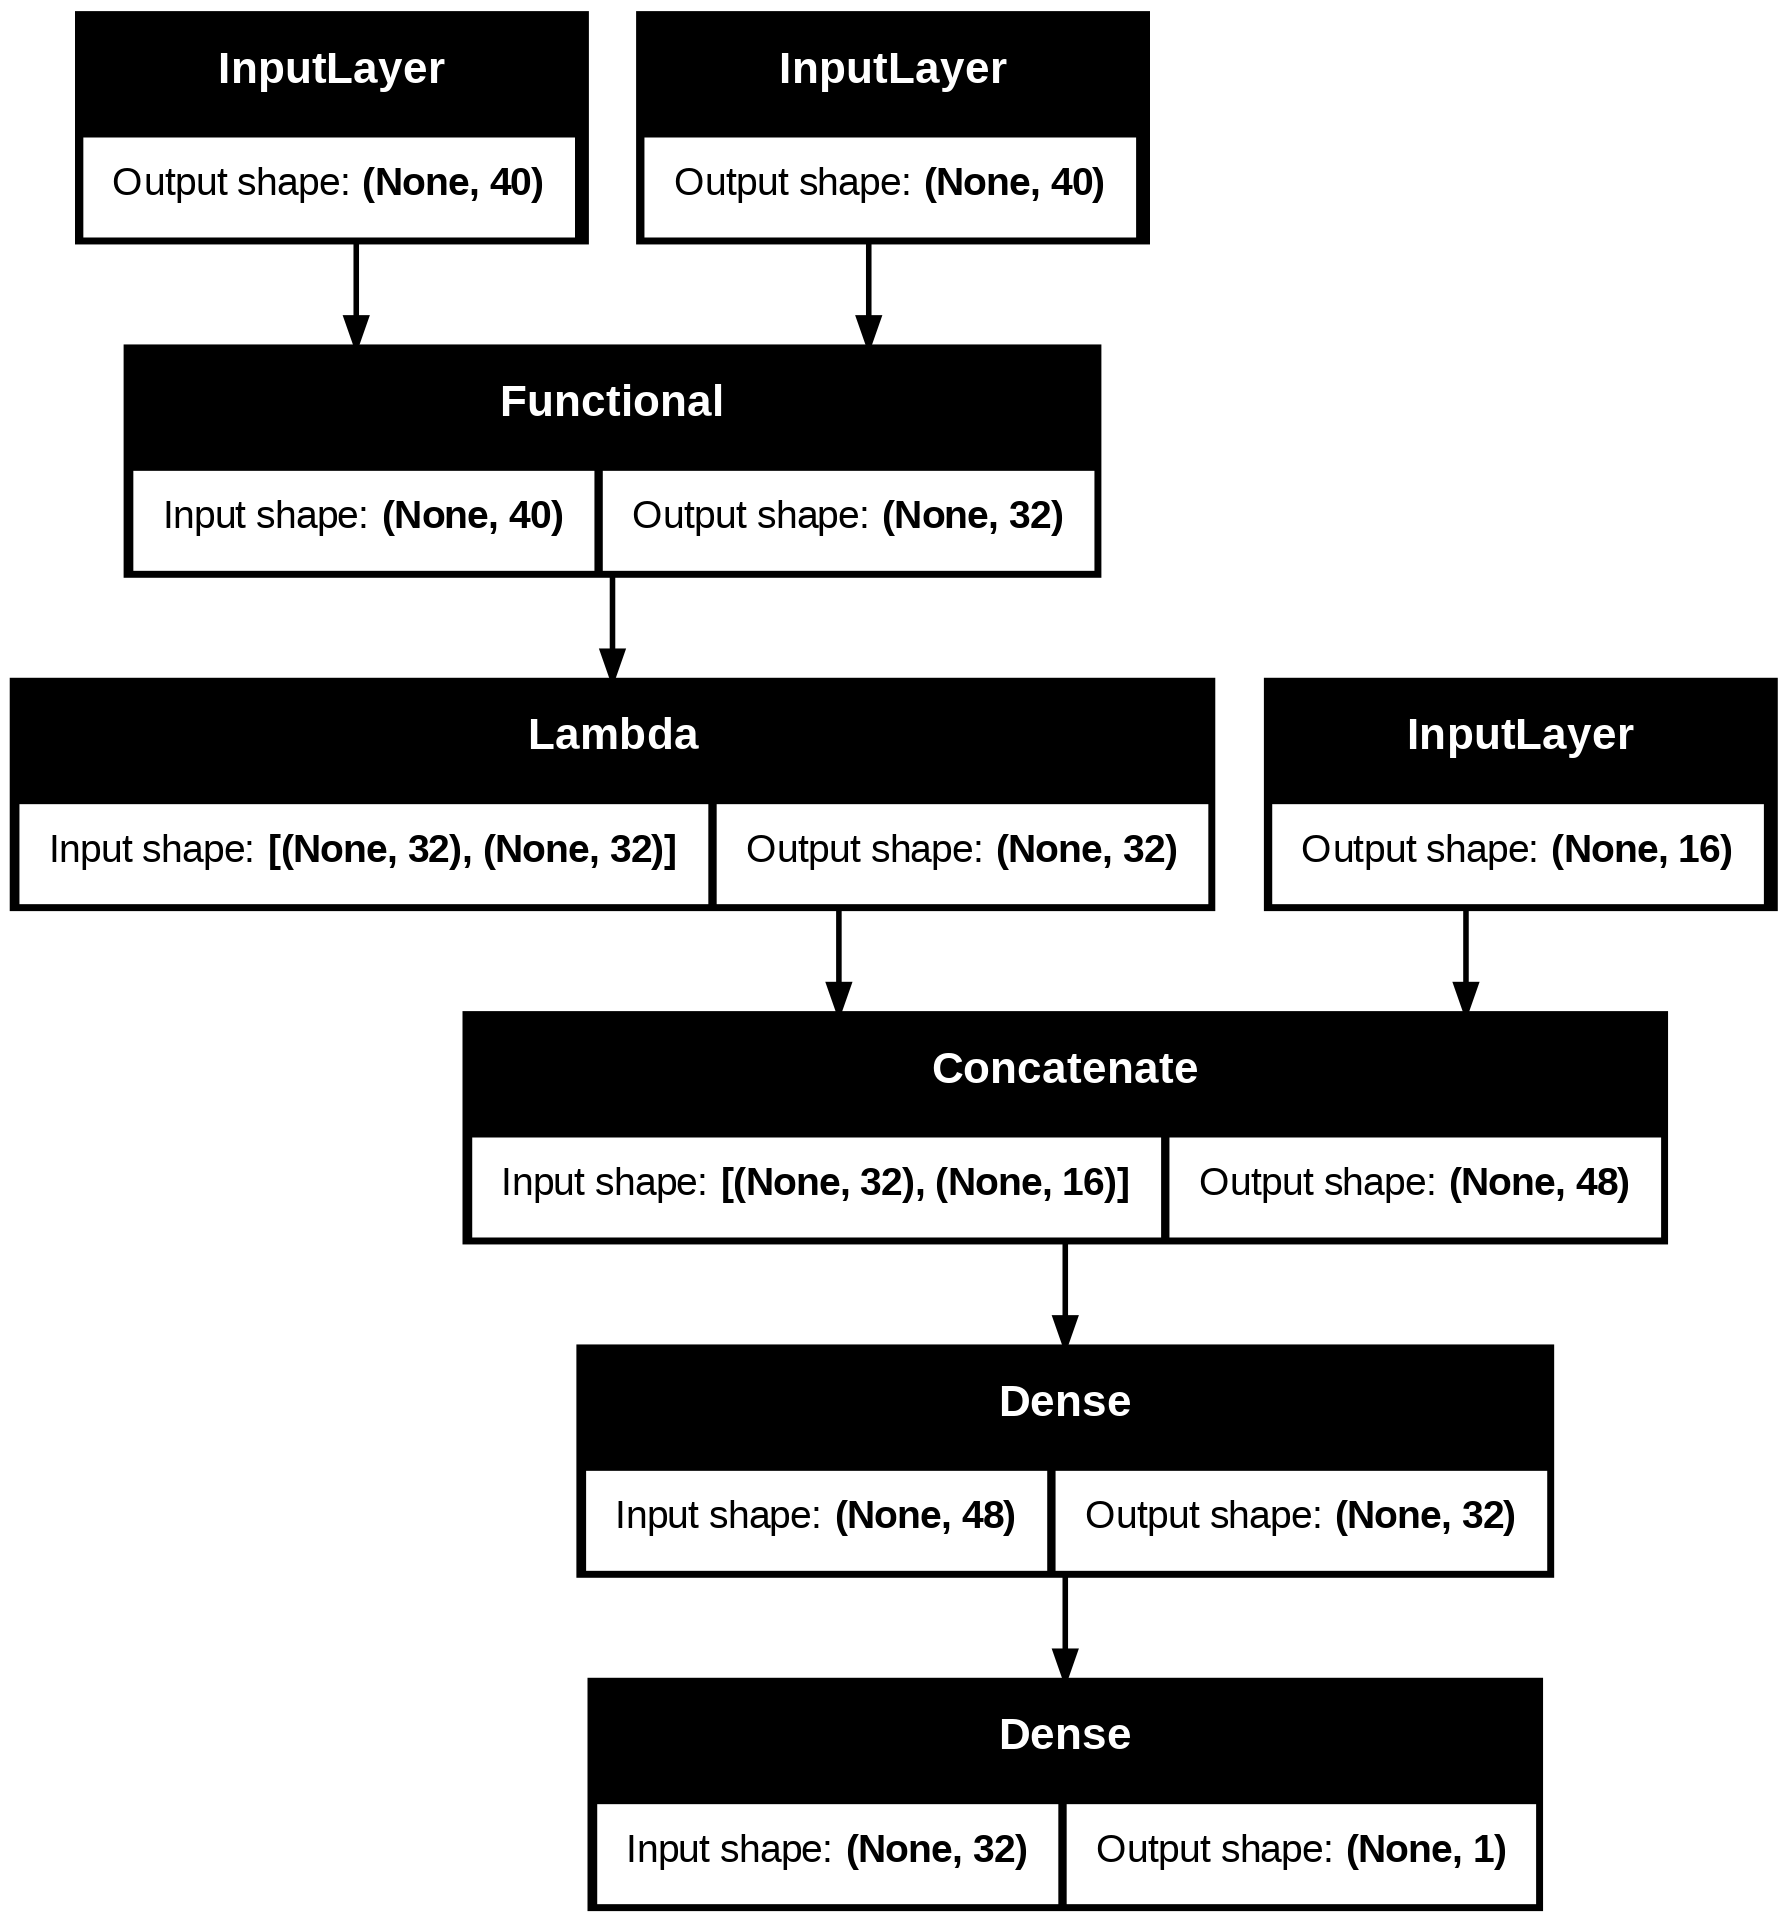

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
q1_seq_train = tokenizer.texts_to_sequences(df_train['question1'])
q2_seq_train = tokenizer.texts_to_sequences(df_train['question2'])
q1_seq_test = tokenizer.texts_to_sequences(df_test['question1'])
q2_seq_test = tokenizer.texts_to_sequences(df_test['question2'])

q1_pad_train = pad_sequences(q1_seq_train, maxlen=max_seq_length, padding='post')
q2_pad_train = pad_sequences(q2_seq_train, maxlen=max_seq_length, padding='post')
q1_pad_test = pad_sequences(q1_seq_test, maxlen=max_seq_length, padding='post')
q2_pad_test = pad_sequences(q2_seq_test, maxlen=max_seq_length, padding='post')



# Fit the model using separate inputs
history = model.fit(
    [q1_pad_train, q2_pad_train, X_feat_train], y_train,
    epochs=10,
    batch_size=128,
    validation_data=([q1_pad_test, q2_pad_test, X_feat_test], y_test
                     ),
    verbose=1
)

Epoch 1/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.7004 - loss: 0.6149 - val_accuracy: 0.7436 - val_loss: 0.4962
Epoch 2/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.7676 - loss: 0.4663 - val_accuracy: 0.7552 - val_loss: 0.4709
Epoch 3/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7833 - loss: 0.4412 - val_accuracy: 0.7492 - val_loss: 0.4757
Epoch 4/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.7916 - loss: 0.4272 - val_accuracy: 0.7667 - val_loss: 0.4640
Epoch 5/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7983 - loss: 0.4156 - val_accuracy: 0.7720 - val_loss: 0.4449
Epoch 6/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8059 - loss: 0.4039 - val_accuracy: 0.7770 - val_loss: 0.4429
Epoch 7/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8104 - loss: 0.3944 - val_accuracy: 0.7883 - val_loss: 0.4335
Epoch 8/10
1983/1983 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8141 -

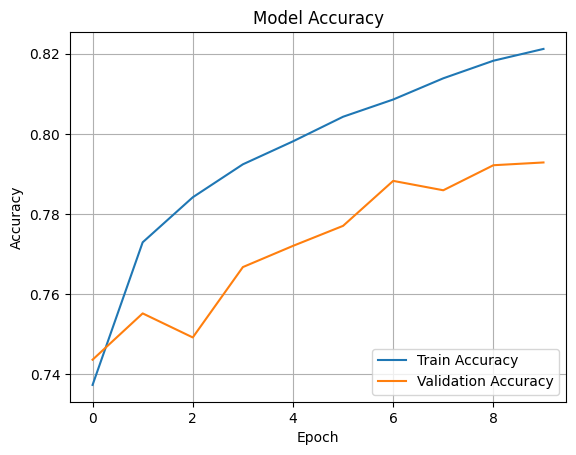

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

###<font color="##00FFFF"> Evaluating Model Performance <a name="section-6"></a>

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

1400/1400 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


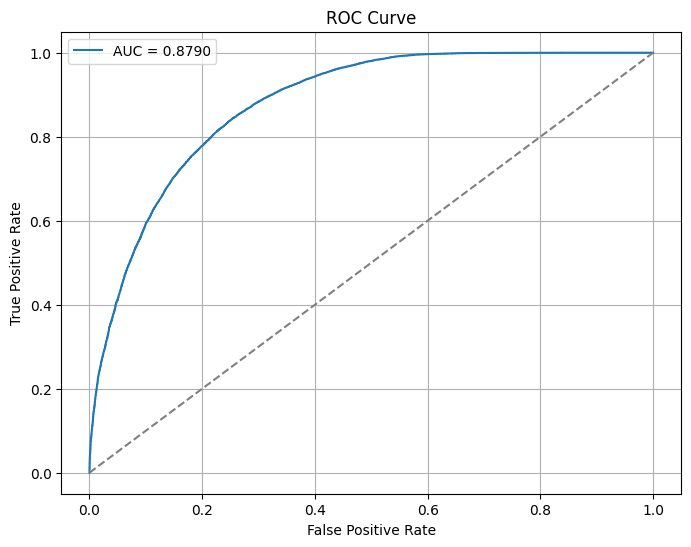

In [ ]:
y_probs = model.predict([q1_pad_test, q2_pad_test, X_feat_test])
y_probs = y_probs.ravel()


fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


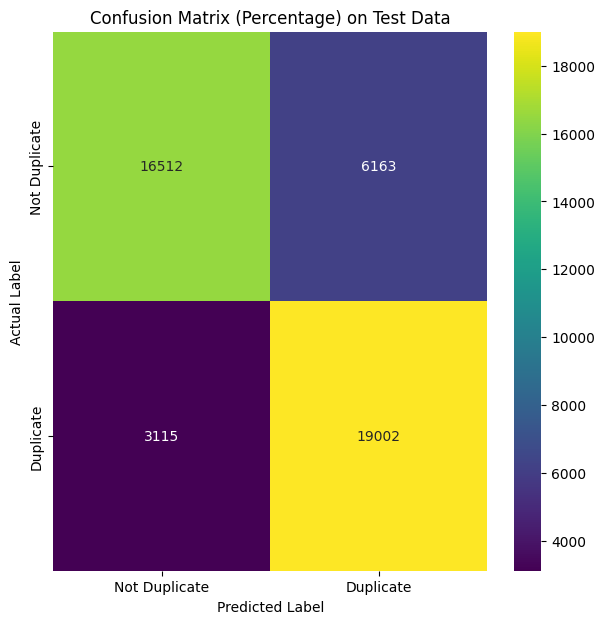

In [ ]:
y_pred = (y_probs >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Not Duplicate', 'Duplicate'],
            yticklabels=['Not Duplicate', 'Duplicate'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (Percentage) on Test Data')
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78     22675
           1       0.76      0.86      0.80     22117

    accuracy                           0.79     44792
   macro avg       0.80      0.79      0.79     44792
weighted avg       0.80      0.79      0.79     44792



In [ ]:
model.save("duplicate_questionCNN_model.keras")